In [2]:
import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [32]:
#데이터 불러오기
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
building_info =  pd.read_csv('./data/building_info.csv')

train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)


train_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [7]:
test_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [8]:
building_info.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other Buildings,110634.00,39570.00,-,-,-
1,2,Other Buildings,122233.47,99000.00,-,-,-
2,3,Other Buildings,171243.00,113950.00,40,-,-
3,4,Other Buildings,74312.98,34419.62,60,-,-
4,5,Other Buildings,205884.00,150000.00,-,2557,1000


Train 과 Test의 차이: columns에 일조, 일사, 전력 소비량이 없다.

## 전처리 (병합, 빈칸 채우기, 형 변환, num_date_time 삭제)

In [9]:
# def preprocessing(df):
  #공통적인 부분만 변경

  #결측값을 0으로 채웁니다 안바꿔도 됨
  df = df.fillna(0)
  #시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
  df['date_time'] = pd.to_datetime(df['date_time'], format='%Y%m%d %H')
  #람다식을 이용해 일시에서 달,일,시간을 잘라낸것
  df['month'] = df['date_time'].dt.month
  df['day'] = df['date_time'].dt.day
  df['hour'] = df['date_time'].dt.hour

  # 'building_number'를 기준으로 두 데이터프레임 병합 및 전처리
  merged_df = pd.merge(df, building_info, on='building_number',how='right')
  #merge후 전처리
  merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].replace('-', 0)
  merged_df['ess_capacity'] = merged_df['ess_capacity'].replace('-', 0)
  merged_df['pcs_capacity'] = merged_df['pcs_capacity'].replace('-', 0)

  merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].astype('float64')
  merged_df['ess_capacity'] = merged_df['ess_capacity'].astype('float64')
  merged_df['pcs_capacity'] = merged_df['pcs_capacity'].astype('float64')

  return merged_df.drop(columns=['num_date_time'])


In [10]:

merged_train_df.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,month,day,hour,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,6,1,0,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,6,1,1,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,6,1,2,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,6,1,3,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,6,1,4,Other Buildings,110634.0,39570.0,0.0,0.0,0.0


In [ ]:
merged_test_df.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,month,day,hour,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,8,25,0,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,8,25,1,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,8,25,2,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,8,25,3,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,8,25,4,Other Buildings,110634.0,39570.0,0.0,0.0,0.0


## 추가 전처리

In [46]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

def merge(df):
    df = df.fillna(0)
    date = pd.to_datetime(df.date_time)
    df['hour'] = date.dt.hour
    df['day'] = date.dt.weekday
    df['month'] = date.dt.month
    df['week'] = date.dt.weekofyear
    
    # 'building_number'를 기준으로 두 데이터프레임 병합 및 전처리
    merged_df = pd.merge(df, building_info, on='building_number',how='right')
    #merge후 전처리
    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].replace('-', 0)
    merged_df['ess_capacity'] = merged_df['ess_capacity'].replace('-', 0)
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].replace('-', 0)

    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].astype('float64')
    merged_df['ess_capacity'] = merged_df['ess_capacity'].astype('float64')
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].astype('float64')
    return merged_df

def preprocessing(df, train = True):
    if train:
        #######################################
        ## 건물별, 요일별, 시간별 발전량 평균 넣어주기
        #######################################
        power_mean = pd.pivot_table(merged_df, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.mean).reset_index()
        tqdm.pandas()
        #######################################
        ## 건물별 시간별 발전량 평균 넣어주기
        #######################################
        power_hour_mean = pd.pivot_table(merged_df, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.mean).reset_index()
        tqdm.pandas()
            #######################################
        ## 건물별 시간별 발전량 표준편차 넣어주기
        #######################################
        power_hour_std = pd.pivot_table(merged_df, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.std).reset_index()
        tqdm.pandas()
    
    df['day_hour_mean'] = df.progress_apply(lambda x : power_mean.loc[(power_mean.building_number == x['building_number']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power_consumption'].values[0], axis = 1)
    df['hour_mean'] = df.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.building_number == x['building_number']) & (power_hour_mean.hour == x['hour']) ,'power_consumption'].values[0], axis = 1)   
    df['hour_std'] = df.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.building_number == x['building_number']) & (power_hour_std.hour == x['hour']) ,'power_consumption'].values[0], axis = 1)
    
    def CDH(xs):
        ys = []
        for i in range(len(xs)):
            if i < 11:
                ys.append(np.sum(xs[:(i+1)]-26))
            else:
                ys.append(np.sum(xs[(i-11):(i+1)]-26))
        return np.array(ys)

    cdhs = np.array([])
    for num in range(1,101,1):
        temp = df[df['building_number'] == num]
        cdh = CDH(temp['temperature'].values)
        cdhs = np.concatenate([cdhs, cdh])
    df['CDH'] = cdhs

    
    
    
    ### 공휴일 변수 추가
    df['holiday'] = df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
    df.loc[('2022-08-17'<=df.date_time)&(df.date_time<'2022-08-18'), 'holiday'] = 1

    ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
    df['sin_time'] = np.sin(2*np.pi*df.hour/24)
    df['cos_time'] = np.cos(2*np.pi*df.hour/24)
    
    ## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
    df['THI'] = 9/5*df['temperature'] - 0.55*(1-df['humidity']/100)*(9/5*df['humidity']-26)+32
    
    
    return df.drop(columns =['num_date_time','date_time'])

In [47]:

# 시간 관련 변수들 생성
power_mean = pd.DataFrame()
power_hour_mean = pd.DataFrame()
power_hour_std = pd.DataFrame()

merged_train_df = merge(train_df)
merged_test_df = merge(test_df)


TypeError: merge() takes 1 positional argument but 2 were given

In [18]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   building_number       204000 non-null  int64         
 1   date_time             204000 non-null  datetime64[ns]
 2   temperature           204000 non-null  float64       
 3   rainfall              204000 non-null  float64       
 4   windspeed             204000 non-null  float64       
 5   humidity              204000 non-null  float64       
 6   sunshine              204000 non-null  float64       
 7   solar_radiation       204000 non-null  float64       
 8   power_consumption     204000 non-null  float64       
 9   month                 204000 non-null  int64         
 10  day                   204000 non-null  int64         
 11  hour                  204000 non-null  int64         
 12  building_type         204000 non-null  object        
 13 

In [17]:
merged_train_df.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,month,day,hour,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,day_hour_mean,hour_std,holiday,sin_time,cos_time,THI
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,6,1,0,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,1371.52,446.882767,0,0.000000,1.000000,49.6576
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,6,1,1,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,1323.52,439.662704,0,0.258819,0.965926,47.7625
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,6,1,2,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,1236.48,412.071906,0,0.500000,0.866025,47.2225
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,6,1,3,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,1189.92,391.205981,0,0.707107,0.707107,44.7856
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,6,1,4,Other Buildings,110634.0,39570.0,0.0,0.0,0.0,1210.08,381.099697,0,0.866025,0.500000,49.0061


In [ ]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = merged_train_df[merged_train_df['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
merged_train_df['CDH'] = cdhs

In [ ]:
## save the preprocessed data
merged_train_df.to_csv('./data/train_preprocessed.csv')

## 원핫 인코딩(안해도 됨)

In [ ]:
merged_train_df = pd.get_dummies(merged_train_df, prefix=["bt:"], columns=["building_type"])
merged_train_df.head()

In [ ]:
merged_test_df = pd.get_dummies(merged_test_df, prefix=["bt:"], columns=["building_type"])
merged_test_df.head()

,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,month,day,time,...,bt:_Data Center,bt:_Department Store and Outlet,bt:_Discount Mart,bt:_Hospital,bt:_Hotel and Resort,bt:_Knowledge Industry Center,bt:_Other Buildings,bt:_Public,bt:_Research Institute,bt:_University
0,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,6,1,0,...,0,0,0,0,0,0,1,0,0,0
1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,6,1,1,...,0,0,0,0,0,0,1,0,0,0
2,17.7,0.0,1.5,45.0,0.0,0.0,974.88,6,1,2,...,0,0,0,0,0,0,1,0,0,0
3,16.7,0.0,1.4,48.0,0.0,0.0,953.76,6,1,3,...,0,0,0,0,0,0,1,0,0,0
4,18.4,0.0,2.8,43.0,0.0,0.0,986.40,6,1,4,...,0,0,0,0,0,0,1,0,0,0


## 성능 평가지표 정의 및 SMAPE 정의

In [21]:
merged_train_df = pd.read_csv('./data/train_preprocessed.csv')
merged_train_df = merged_train_df.drop(columns=['Unnamed: 0','building_type','date_time'])

In [22]:
merged_train_df.head()

,building_number,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,month,day,hour,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,day_hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,6,1,0,110634.0,39570.0,0.0,0.0,0.0,1371.52,446.882767,0,0.000000,1.000000,49.6576,-7.4
1,1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,6,1,1,110634.0,39570.0,0.0,0.0,0.0,1323.52,439.662704,0,0.258819,0.965926,47.7625,-15.4
2,1,17.7,0.0,1.5,45.0,0.0,0.0,974.88,6,1,2,110634.0,39570.0,0.0,0.0,0.0,1236.48,412.071906,0,0.500000,0.866025,47.2225,-23.7
3,1,16.7,0.0,1.4,48.0,0.0,0.0,953.76,6,1,3,110634.0,39570.0,0.0,0.0,0.0,1189.92,391.205981,0,0.707107,0.707107,44.7856,-33.0
4,1,18.4,0.0,2.8,43.0,0.0,0.0,986.40,6,1,4,110634.0,39570.0,0.0,0.0,0.0,1210.08,381.099697,0,0.866025,0.500000,49.0061,-40.6


In [23]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

## 최적의 파라미터 탐색

In [ ]:
from sklearn.model_selection import PredefinedSplit, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer

df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)

# Initialize the time series split
tscv = TimeSeriesSplit(n_splits=3)

for i in tqdm(np.arange(1, 101)):
    y = merged_test_df.loc[merged_test_df.num == i, 'power']
    x = merged_test_df.loc[merged_test_df.num == i, ].iloc[:, 3:]
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    smape_score = make_scorer(SMAPE, greater_is_better=False)

    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0),
                       param_grid = grid, scoring = smape_score, cv = pds, refit = True, verbose = True)


    gcv.fit(x_train, y_train)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('./hyperparameter_xgb.csv', index = False) # save the tuned parameters

  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 3 folds for each of 168 candidates, totalling 504 fits


  1%|          | 1/100 [01:55<3:11:00, 115.77s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
1 || SMAPE :  -54.970587712612605
Fitting 3 folds for each of 168 candidates, totalling 504 fits


## 학습

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

xgb_params = pd.read_csv('./parameters/hyperparameter_xgb.csv')
scores = []   # smape 값을 저장할 list
models = []  # best interation을 저장할 list
for i in tqdm(range(100)):   
    x = merged_train_df.loc[merged_train_df['building_number'] == building_number].drop('power_consumption', axis=1)
    y = merged_train_df.loc[merged_train_df['building_number'] == building_number, 'power_consumption']


    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4],
                           subsample = xgb_params.iloc[i, 5], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)

    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    models.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.

## 테스트

In [24]:
merged_test_df.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,month,day,hour,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,8,25,0,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,8,25,1,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,8,25,2,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,8,25,3,Other Buildings,110634.0,39570.0,0.0,0.0,0.0
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,8,25,4,Other Buildings,110634.0,39570.0,0.0,0.0,0.0


In [ ]:
# train set과 동일한 전처리 과정

cols = ['num', 'date_time', 'temp', 'wind','hum' ,'prec', 'sun', 'non_elec', 'solar']
merged_test_df.columns = cols
date = pd.to_datetime(merged_test_df.date_time)
merged_test_df['hour'] = date.dt.hour
merged_test_df['day'] = date.dt.weekday
merged_test_df['month'] = date.dt.month
#merged_test_df['week'] = date.dt.weekofyear
merged_test_df['sin_time'] = np.sin(2*np.pi*merged_test_df.hour/24)
merged_test_df['cos_time'] = np.cos(2*np.pi*merged_test_df.hour/24)
merged_test_df['holiday'] = merged_test_df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
merged_test_df.loc[('2020-08-17'<=merged_test_df.date_time)&(merged_test_df.date_time<'2020-08-18'), 'holiday'] = 1

## 건물별 일별 시간별 발전량 평균
tqdm.pandas()
merged_test_df['day_hour_mean'] = merged_test_df.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.day == x['day']) & (power_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

## 건물별 시간별 발전량 평균 넣어주기
tqdm.pandas()
merged_test_df['hour_mean'] = merged_test_df.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['hour_std'] = test.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

test.drop(['non_elec', 'solar','hour','date_time'], axis = 1, inplace = True)

# pandas 내 선형보간 method 사용
for i in range(60):
    test.iloc[i*168:(i+1)*168, :]  = test.iloc[i*168:(i+1)*168, :].interpolate()


test['THI'] = 9/5*test['temp'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32

cdhs = np.array([])
for num in range(1,61,1):
    temp = test[test['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

test = test[['num','temp', 'wind', 'hum', 'prec', 'sun', 'day', 'month', 'week',
       'day_hour_mean', 'hour_mean', 'hour_std', 'holiday', 'sin_time',
       'cos_time', 'THI', 'CDH']]
test.head()

In [ ]:
# 테스트 데이터셋을 로드합니다. 이 예에서는 pandas DataFrame을 사용하고 있습니다.
# test_df = pandas.read_csv('your_test_dataset.csv')

predictions = {}

for building_number in models.keys():
    # 건물 번호에 따라 데이터를 분할합니다.
    building_data = test_df[test_df['building_number'] == building_number]

    # 특징을 분할합니다.
    X_test = building_data.drop('target', axis=1)

    # 해당 건물 번호의 모델로 예측을 수행합니다.
    y_pred = models[building_number].predict(X_test)

    # 예측 결과를 딕셔너리에 저장합니다.
    predictions[building_number] = y_pred


Feature 0: 0.003486732253804803
Feature 1: 0.0019662126433104277
Feature 2: 0.004304919857531786
Feature 3: 0.004288780502974987
Feature 4: 0.003691040212288499
Feature 5: 0.026914382353425026


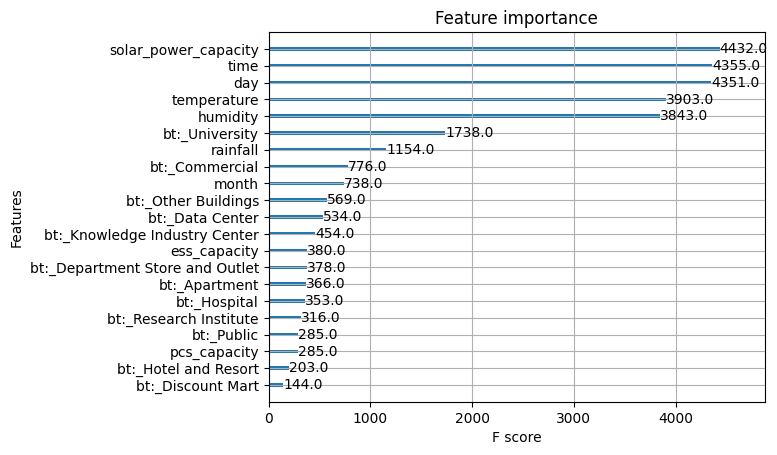

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 피처 중요도 확인
feature_importances = model.feature_importances_

# 피처 중요도를 출력합니다.(위에서 5개만)
for i, feat_importance in enumerate(feature_importances):
  if i <6:
    print(f"Feature {i}: {feat_importance}")

# 피처 중요도를 시각화합니다.
xgb.plot_importance(model)
plt.show()

## 제출

In [ ]:
pred = model.predict(merged_test_df.drop(columns=['windspeed','total_area','cooling_area']))
submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
submission['answer'] = pred
submission.to_csv('/content/drive/MyDrive/data/baseline_submission_0723.csv', index=False)